## Customer Churn Rate

In [1]:
# Import necessary libraries
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV


import graphviz 
#!pip install graphviz

### Data wragling

In [43]:
# import from csv
data0 = pd.read_csv('bankchurners.csv')
data1 = pd.read_csv('enriched_churn_data.csv')
data2 = pd.read_csv('basic_client_info.csv')

In [44]:
# merge all tables
data01 = pd.merge(data0, data1, on='clientnum')
data = pd.merge(data01, data2, on='clientnum')
df = pd.DataFrame(data=data)

In [45]:
pd.set_option('max_colwidth', 10)
pd.set_option('display.max_columns', 21)
df.sample(10)

,clientnum,attrition_flag,dependent_count,card_category,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio,total_relationship_count,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct,customer_age,gender,education_level,marital_status,income_category
8998,797466033,Existi...,1,Blue,26,2,3,2576.0,822.0,0.681,3,1754,1.027,2880,0.468,69,32,M,High S...,Married,$40K -...
3201,786557358,Existi...,1,Blue,38,2,4,3242.0,2443.0,0.246,5,799,0.459,1424,0.028,37,44,F,Unknown,Married,Less t...
6130,714690633,Existi...,3,Blue,36,3,1,3276.0,1802.0,0.450,1,1474,0.759,14212,0.681,116,51,F,Graduate,Single,Less t...
98,714418158,Existi...,0,Blue,56,2,2,7264.0,6413.0,0.117,2,851,0.814,3527,0.816,69,63,F,Uneduc...,Single,Less t...
2526,718435158,Existi...,3,Blue,40,1,4,34516.0,34516.0,0.000,5,0,0.986,1930,0.440,36,50,M,High S...,Married,$120K +
8671,778722033,Existi...,2,Blue,28,2,0,2275.0,1010.0,0.556,2,1265,0.755,5626,1.081,77,44,F,Uneduc...,Married,Less t...
4107,709380333,Existi...,1,Blue,36,2,3,24545.0,22810.0,0.071,6,1735,0.664,1671,0.500,45,57,M,Uneduc...,Married,$120K +
9040,789248958,Existi...,2,Blue,26,2,3,2946.0,429.0,0.854,3,2517,0.841,5259,0.780,89,37,F,High S...,Married,$40K -...
6076,721264533,Existi...,3,Blue,36,1,3,3767.0,2661.0,0.294,1,1106,0.944,15578,0.826,126,49,F,Unknown,Married,Less t...
5245,708338958,Existi...,1,Blue,36,1,1,3173.0,1460.0,0.540,5,1713,0.609,3797,0.786,75,58,F,Graduate,Single,Less t...


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   clientnum                 10127 non-null  int64  
 1   attrition_flag            10127 non-null  object 
 2   dependent_count           10127 non-null  int64  
 3   card_category             10127 non-null  object 
 4   months_on_book            10127 non-null  int64  
 5   months_inactive_12_mon    10127 non-null  int64  
 6   contacts_count_12_mon     10127 non-null  int64  
 7   credit_limit              10127 non-null  float64
 8   avg_open_to_buy           10127 non-null  float64
 9   avg_utilization_ratio     10127 non-null  float64
 10  total_relationship_count  10127 non-null  int64  
 11  total_revolving_bal       10127 non-null  int64  
 12  total_amt_chng_q4_q1      10127 non-null  float64
 13  total_trans_amt           10127 non-null  int64  
 14  total_

### Data Cleaning

In [47]:
#make a copy
df_clean = df.copy()

In [7]:
#check duplicates
df_clean.duplicated().sum()

0

In [8]:
#check nulls
df_clean.attrition_flag.isna().sum()

0

In [9]:
## Pre-processing

In [10]:
categorical_cols = [c for c in df_clean.columns if df_clean[c].dtype == 'object']
categorical_cols               

['attrition_flag',
 'card_category',
 'gender',
 'education_level',
 'marital_status',
 'income_category']

In [11]:
numerical_cols = [n for n in df_clean.columns if df_clean[n].dtype != 'object']
numerical_cols  

['clientnum',
 'dependent_count',
 'months_on_book',
 'months_inactive_12_mon',
 'contacts_count_12_mon',
 'credit_limit',
 'avg_open_to_buy',
 'avg_utilization_ratio',
 'total_relationship_count',
 'total_revolving_bal',
 'total_amt_chng_q4_q1',
 'total_trans_amt',
 'total_ct_chng_q4_q1',
 'total_trans_ct',
 'customer_age']

In [12]:
numerical_cols = ['contacts_count_12_mon', 'months_on_book', 'months_inactive_12_mon']
df[numerical_cols].describe()

,contacts_count_12_mon,months_on_book,months_inactive_12_mon
count,10127....,10127....,10127....
mean,2.455317,35.928409,2.341167
std,1.106225,7.986416,1.010622
min,0.000000,13.000000,0.000000
25%,2.000000,31.000000,2.000000
50%,2.000000,36.000000,2.000000
75%,3.000000,40.000000,3.000000
max,6.000000,56.000000,6.000000


In [48]:
df_clean.attrition_flag.value_counts() #below the anual churning rate?

Existing Customer    8500
Attrited Customer    1627
Name: attrition_flag, dtype: int64

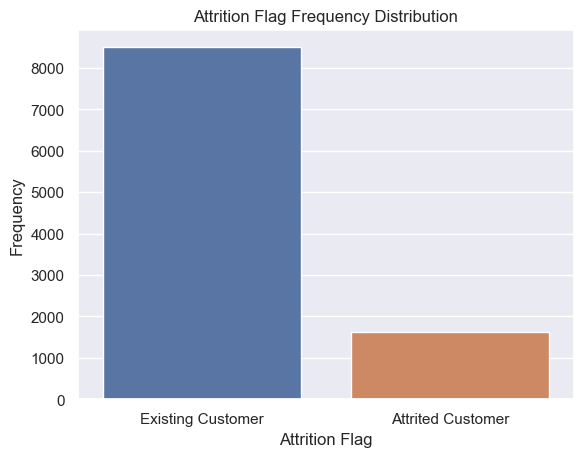

In [49]:
sns.countplot(x='attrition_flag', data=df_clean)
plt.title('Attrition Flag Frequency Distribution')
plt.xlabel('Attrition Flag')
plt.ylabel('Frequency')
plt.show()

In [14]:
df_clean['churned'] = df_clean['attrition_flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})


In [15]:
# Calculate the percentage of churned customers
num_churned = df_clean[df_clean["churned"] == 1].shape[0]
num_total = df_clean.shape[0]
percent_churned = (num_churned / num_total) * 100

# Format the result as a percentage
print("Percentage of churned customers: {:.2f}%".format(percent_churned))


Percentage of churned customers: 16.07%


In [17]:
df_clean

,clientnum,dependent_count,card_category,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio,total_relationship_count,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct,customer_age,gender,education_level,marital_status,income_category,churned
0,806160108,1,Blue,56,2,3,3193.0,676.0,0.788,2,2517,1.831,1336,1.143,30,61,M,High S...,Married,$40K -...,0
1,804424383,1,Blue,56,3,2,10215.0,9205.0,0.099,3,1010,0.843,1904,1.000,40,63,M,Unknown,Married,$60K -...,0
2,708300483,0,Blue,56,4,3,7882.0,7277.0,0.077,5,605,1.052,704,0.143,16,66,F,Doctorate,Married,Unknown,1
3,808284783,1,Blue,56,0,0,1438.3,1438.3,0.000,6,0,0.813,1951,1.095,44,62,F,Unknown,Married,Less t...,0
4,712720158,1,Blue,56,2,3,13860.0,12208.0,0.119,5,1652,1.255,1910,1.909,32,68,M,Graduate,Married,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,714082308,3,Blue,13,1,3,8656.0,8656.0,0.000,2,0,0.893,8056,0.935,89,39,M,High S...,Single,$80K -...,1
10123,710751033,1,Blue,13,1,3,4829.0,4829.0,0.000,1,0,0.836,8286,0.857,65,31,F,Graduate,Single,Less t...,1
10124,780118158,0,Blue,13,2,4,3585.0,1165.0,0.675,2,2420,0.812,15656,0.746,124,27,M,Graduate,Single,Less t...,0
10125,779082633,2,Blue,13,2,3,4107.0,3128.0,0.238,3,979,0.647,14596,0.733,104,30,M,Uneduc...,Single,$60K -...,0


#### Observations

The annual churn rate for credit cards can vary greatly depending on the type of card and the target demographic. On average, it is common to see an annual churn rate of around 20% for credit cards. However, some high-end, premium credit cards may have a lower churn rate, while cards targeted towards subprime borrowers may have a higher churn rate.

It's important to note that a lower churn rate is typically seen as a positive sign for a credit card issuer, as it indicates that customers are satisfied with the card and less likely to switch to a different one. On the other hand, a higher churn rate can indicate that customers are not satisfied with the card or are switching to a different one with more attractive terms.

A preliminary overview of the dataset shows that around 83.93% of customers are active, while 16.07% have churned.

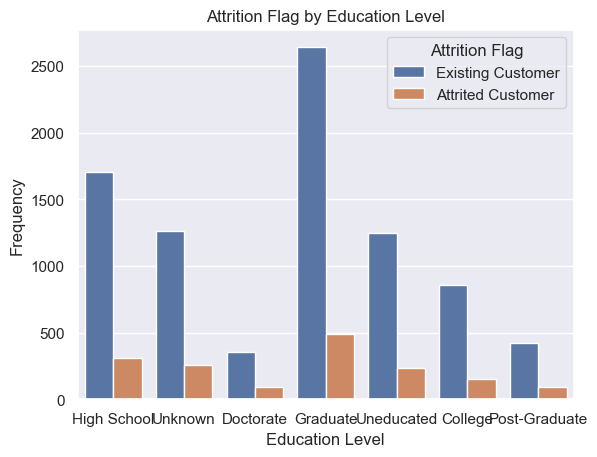

In [51]:
sns.countplot(x='education_level', hue='attrition_flag', data=df_clean)
plt.title('Attrition Flag by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Frequency')
plt.legend(title='Attrition Flag')
plt.show()


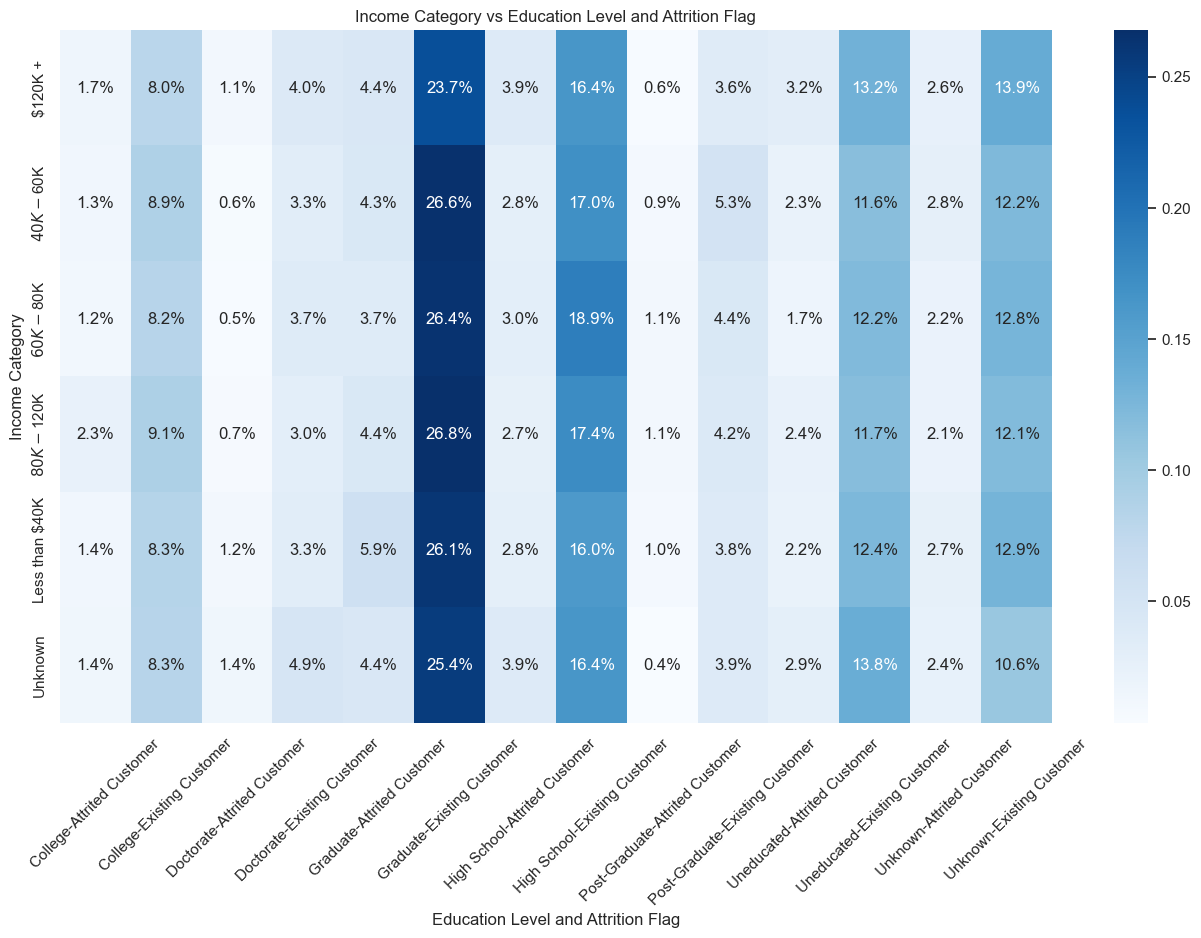

In [58]:
plt.figure(figsize=(16, 9))
sns.set(font_scale=1)
sns.heatmap(pd.crosstab(df_clean['income_category'], [df_clean['education_level'], df_clean['attrition_flag']], normalize='index'),
            cmap='Blues', annot=True, fmt='.1%')
plt.title('Income Category vs Education Level and Attrition Flag')
plt.xlabel('Education Level and Attrition Flag')
plt.ylabel('Income Category')
plt.xticks(rotation=45)
plt.show()


In [18]:
#Convert 'gender'to fullname
dict_g = {
         'F' : ['Female'],
         'M' :[' Male'],
         
        
    }
df_clean['gender'] = df_clean['gender']
df_clean.replace({"gender": dict_g},inplace=True)

In [19]:
df.describe(include='object')

,attrition_flag,card_category,gender,education_level,marital_status,income_category
count,10127,10127,10127,10127,10127,10127
unique,2,4,2,7,4,6
top,Existi...,Blue,F,Graduate,Married,Less t...
freq,8500,9436,5358,3128,4687,3561


In [20]:
df_clean.describe().loc[['min','max','mean']].round(2)

,clientnum,dependent_count,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio,total_relationship_count,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct,customer_age,churned
min,7.0808...,0.00,13.00,0.00,0.00,1438.30,3.00,0.00,1.00,0.00,0.00,510.00,0.00,10.00,26.00,0.00
max,8.2834...,5.00,56.00,6.00,6.00,34516.00,34516.00,1.00,6.00,2517.00,3.40,18484.00,3.71,139.00,73.00,1.00
mean,7.3917...,2.35,35.93,2.34,2.46,8631.95,7469.14,0.27,3.81,1162.81,0.76,4404.09,0.71,64.86,46.33,0.16


In [42]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10127 entries, 0 to 10126
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   dependent_count           10127 non-null  int64  
 1   card_category             10127 non-null  object 
 2   months_on_book            10127 non-null  int64  
 3   months_inactive_12_mon    10127 non-null  int64  
 4   contacts_count_12_mon     10127 non-null  int64  
 5   credit_limit              10127 non-null  float64
 6   avg_open_to_buy           10127 non-null  float64
 7   avg_utilization_ratio     10127 non-null  float64
 8   total_relationship_count  10127 non-null  int64  
 9   total_revolving_bal       10127 non-null  int64  
 10  total_amt_chng_q4_q1      10127 non-null  float64
 11  total_trans_amt           10127 non-null  int64  
 12  total_ct_chng_q4_q1       10127 non-null  float64
 13  total_trans_ct            10127 non-null  int64  
 14  custom

In [41]:
sns.countplot(x='attrition_flag', data=df_clean)
plt.title('Attrition Flag Frequency Distribution')
plt.xlabel('Attrition Flag')
plt.ylabel('Frequency')
plt.show()



ValueError: Could not interpret input 'attrition_flag'

In [22]:
df_churned = df_clean[df_clean['churned'] == 1]
df_churned

,clientnum,dependent_count,card_category,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio,total_relationship_count,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct,customer_age,gender,education_level,marital_status,income_category,churned
2,708300483,0,Blue,56,4,3,7882.0,7277.0,0.077,5,605,1.052,704,0.143,16,66,Female,Doctorate,Married,Unknown,1
13,794977533,0,Blue,56,3,2,8077.0,8077.0,0.000,3,0,0.749,906,0.333,16,62,Male,High S...,Married,$60K -...,1
16,812420358,0,Blue,56,3,3,2122.0,1568.0,0.261,3,554,0.857,949,0.133,17,61,Female,Graduate,Married,Less t...,1
17,802002858,1,Blue,56,1,2,8990.0,8990.0,0.000,2,0,0.935,747,0.583,19,62,Female,High S...,Married,Unknown,1
33,816013383,0,Blue,56,6,3,6184.0,6184.0,0.000,3,0,1.016,1712,0.286,27,65,Female,Graduate,Divorced,Less t...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10090,787463508,0,Blue,13,2,4,2469.0,59.0,0.976,5,2410,0.544,1027,0.176,20,26,Male,Graduate,Single,Less t...,1
10091,710586483,0,Blue,13,2,4,6152.0,6152.0,0.000,1,0,0.391,968,0.533,23,26,Female,High S...,Single,Unknown,1
10118,710153583,0,Blue,13,1,3,6075.0,6075.0,0.000,3,0,0.923,9242,0.909,63,30,Female,Uneduc...,Married,Less t...,1
10122,714082308,3,Blue,13,1,3,8656.0,8656.0,0.000,2,0,0.893,8056,0.935,89,39,Male,High S...,Single,$80K -...,1


In [25]:
df_clean

,clientnum,dependent_count,card_category,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio,total_relationship_count,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct,customer_age,gender,education_level,marital_status,income_category,churned
0,806160108,1,Blue,56,2,3,3193.0,676.0,0.788,2,2517,1.831,1336,1.143,30,61,Male,High S...,Married,$40K -...,0
1,804424383,1,Blue,56,3,2,10215.0,9205.0,0.099,3,1010,0.843,1904,1.000,40,63,Male,Unknown,Married,$60K -...,0
2,708300483,0,Blue,56,4,3,7882.0,7277.0,0.077,5,605,1.052,704,0.143,16,66,Female,Doctorate,Married,Unknown,1
3,808284783,1,Blue,56,0,0,1438.3,1438.3,0.000,6,0,0.813,1951,1.095,44,62,Female,Unknown,Married,Less t...,0
4,712720158,1,Blue,56,2,3,13860.0,12208.0,0.119,5,1652,1.255,1910,1.909,32,68,Male,Graduate,Married,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,714082308,3,Blue,13,1,3,8656.0,8656.0,0.000,2,0,0.893,8056,0.935,89,39,Male,High S...,Single,$80K -...,1
10123,710751033,1,Blue,13,1,3,4829.0,4829.0,0.000,1,0,0.836,8286,0.857,65,31,Female,Graduate,Single,Less t...,1
10124,780118158,0,Blue,13,2,4,3585.0,1165.0,0.675,2,2420,0.812,15656,0.746,124,27,Male,Graduate,Single,Less t...,0
10125,779082633,2,Blue,13,2,3,4107.0,3128.0,0.238,3,979,0.647,14596,0.733,104,30,Male,Uneduc...,Single,$60K -...,0


### EDA

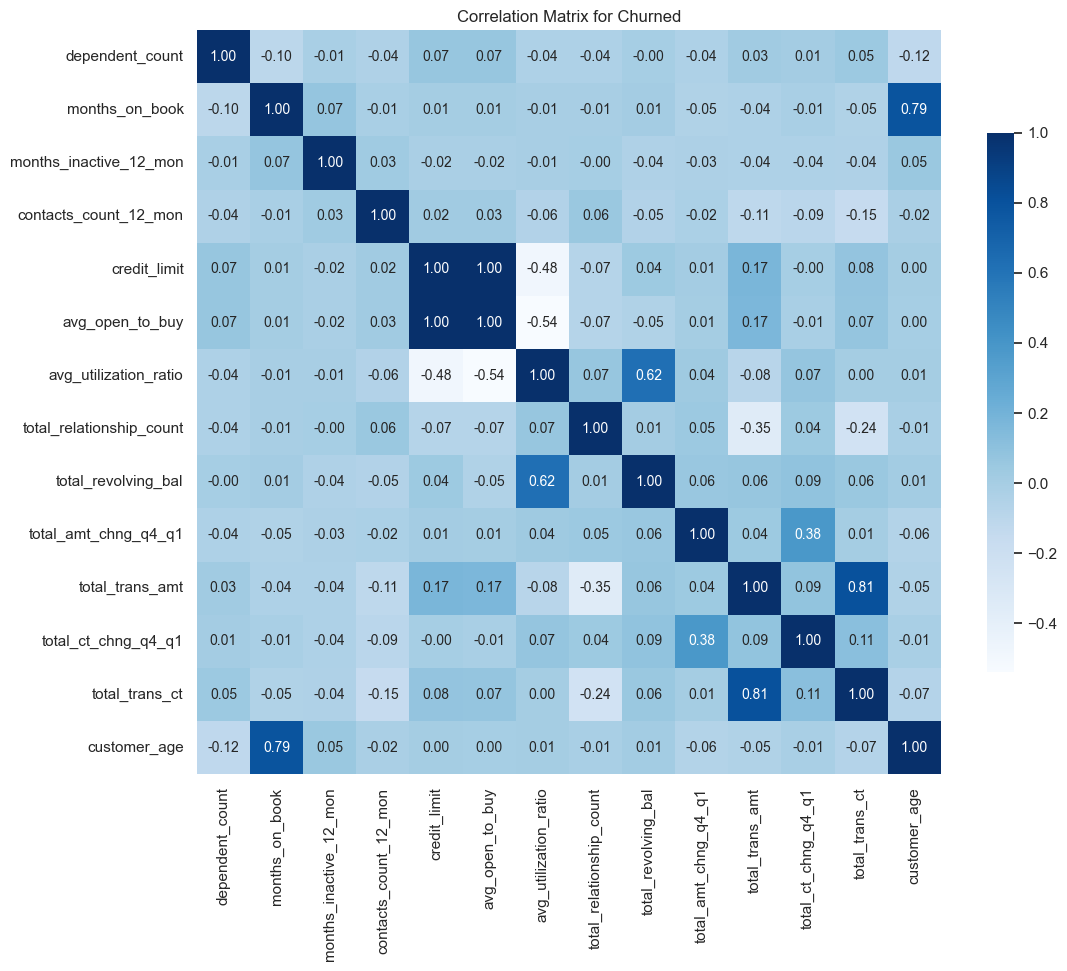

In [26]:
#drop first two columns which are not predictive
df_ = df_clean.drop(['clientnum'],axis=1, inplace=True)
df = df_clean.iloc[:,0:-2]
# Generate a correlation matrix
corr_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.set(font_scale=1)
sns.heatmap(corr_matrix,
            cmap='Blues',
            annot=True,
            fmt='.2f',
            square=True,
            annot_kws={'size': 10},
            cbar_kws={'shrink': 0.7},
            xticklabels=1,
            yticklabels=1)
plt.xticks(rotation=90)
plt.title('Correlation Matrix for Churned')
plt.show()

In [29]:
import pandas as pd



# Select only the rows where the customer has churned
churned_df = df_clean[df_clean['churned'] == 1]

# Calculate the correlation matrix
corr_matrix = churned_df.corr()


print(churn_corr)



dependent_count            NaN
months_on_book             NaN
months_inactive_12_mon     NaN
contacts_count_12_mon      NaN
credit_limit               NaN
avg_open_to_buy            NaN
avg_utilization_ratio      NaN
total_relationship_count   NaN
total_revolving_bal        NaN
total_amt_chng_q4_q1       NaN
total_trans_amt            NaN
total_ct_chng_q4_q1        NaN
total_trans_ct             NaN
customer_age               NaN
churned                    NaN
Name: churned, dtype: float64


In [ ]:
#drop first two columns which are not predictive
df_churned = df_clean.drop(['clientnum','attrition_flag'],axis=1)
df_churned = df.iloc[:,0:-2]
# Generate a correlation matrix
corr_matrix = df_churned.corr()

# Set a threshold for displaying correlations
thresh = 0.5
corr_matrix[abs(corr_matrix) < thresh] = 0

plt.figure(figsize=(12, 10))
sns.set(font_scale=1)
sns.heatmap(corr_matrix,
            cmap='Blues',
            annot=True,
            fmt='.2f',
            square=True,
            annot_kws={'size': 10},
            cbar_kws={'shrink': 0.7},
            xticklabels=1,
            yticklabels=1)
plt.xticks(rotation=90)
plt.title('Correlation Matrix for Churned (threshold = {})'.format(thresh))
plt.show()

In [ ]:
# Convert categorical columns to integer codes
df_clean = pd.get_dummies(df_clean, columns=['card_category', 'gender', 'education_level', 'marital_status', 'income_category'])


# Create DMatrix object with categorical support
dtrain = xgb.DMatrix(data=df_clean.drop('churned', axis=1),
                     label=df_clean['churned'],
                     enable_categorical=True)

# Split the dataset into training and testing sets
X = df_clean.drop('churned', axis=1)
y = df_clean['churned']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Create the XGBoost classifier
clf = xgb.XGBClassifier(objective='binary:logistic',
                        max_depth=3,
                        learning_rate=0.1,
                        n_estimators=100)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

In [ ]:
# One-Hot Encoding
df_clean = pd.get_dummies(df_clean, columns=['card_category', 'gender', 'education_level', 'marital_status', 'income_category'])

# Split the dataset into training and testing sets
X = df_clean.drop('churned', axis=1)
y = df_clean['churned']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Hyperparameter Tuning
params = {'max_depth': [3, 5, 7],
          'learning_rate': [0.1, 0.01, 0.001],
          'n_estimators': [100, 500, 1000]}

xgb_clf = xgb.XGBClassifier(objective='binary:logistic')
grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=params,
                           scoring='accuracy',
                           cv=3,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print('Best parameters:', grid_search.best_params_)
print('Best accuracy:', grid_search.best_score_)

# Feature Selection
feature_importances = pd.DataFrame({'feature': X_train.columns,
                                    'importance': grid_search.best_estimator_.feature_importances_})
feature_importances.sort_values('importance', ascending=False, inplace=True)


# Fit the model to the training data using the best hyperparameters
clf = xgb.XGBClassifier(objective='binary:logistic',
                        max_depth=grid_search.best_params_['max_depth'],
                        learning_rate=grid_search.best_params_['learning_rate'],
                        n_estimators=grid_search.best_params_['n_estimators'])

clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


In [ ]:
pd.set_option('max_colwidth', 20)
pd.set_option('display.max_columns', 21)
feature_importances.head()

In [ ]:
# Create arrays for the features and the target: X, y
X, y = df_clean.iloc[:,:-1], df_clean.iloc[:,-1]

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf_ = tree.DecisionTreeClassifier()
clf_ = clf.fit(X, y)

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# One-Hot Encoding
df_clean = pd.get_dummies(df_clean, columns=[ 'card_category', 'gender', 'education_level', 'marital_status', 'income_category'])

# Split the dataset into training and testing sets
X = df_clean.drop('churned', axis=1)
y = df_clean['churned']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Train a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# Train a decision tree classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Generate the dot file
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=X_train.columns,  
                           class_names=['Not Churned', 'Churned'],  
                           filled=True, rounded=True,  
                           special_characters=True)

# Visualize the decision tree using Graphviz
graph = graphviz.Source(dot_data)
graph.render("churn_decision_tree")


In [ ]:
df_clean.columns

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import graphviz
from sklearn.tree import export_graphviz

# Load data and select only churned customers



# One-hot encode categorical variables
df_clean = pd.get_dummies(df_clean, columns=['card_category', 'gender', 'education_level', 'marital_status', 'income_category'])

# Drop unnecessary columns
df_clean.drop( ['clientnum'], axis=1, inplace=True)

# Split the dataset into training and testing sets
X = df_clean
y = df_clean['churned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the decision tree model
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Visualize the decision tree
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=X.columns,  
                           class_names=['Not Churned', 'Churned'],  
                           filled=True, rounded=True,  
                           special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("churned_decision_tree")  


 - The decision tree model appears to have split the dataset based on a specific feature (x[1]), and determined that if the value of that feature is less than or equal to 0.5, then all samples belong to one class (8500 samples) and if the value of the feature is greater than 0.5, then all samples belong to another class (1627 samples). This suggests that the feature used in the split was a strong predictor of whether or not a credit card user would churn.






In [ ]:
# Perform cross_validation: cv_results
cv_results = xgb.cv(dtrain=df_clean, params=params, 
                  nfold=3, num_boost_round=5, 
                  metrics="AUC", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Print the AUC
print((cv_results["test-auc-mean"]).iloc[-1])

In [ ]:
# Plot feature importance
xgb.plot_importance(clf)
plt.show()

 - In the context of XGBoost, the F-score refers to the feature importance score calculated for each feature. The F-score is a measure of the total reduction in the impurity of the model when splitting on a particular feature. It is used to rank the importance of features in the model and can be used to identify the most relevant features for prediction. Features with higher F-scores are considered more important to the model.

### Economics

In [ ]:
# Plot distribution of total transaction count by attrition flag
plt.figure(figsize=(10, 6),dpi=250)
sns.kdeplot(data=df_clean,
            x='total_trans_ct',
            hue='churned',
            fill=True,
            alpha=0.5,
            palette='cool')
plt.title('Distribution of Total Transaction Count by Attrition Flag')
plt.xlabel('Total Transaction Count')
plt.ylabel('Density')
plt.show()

In [ ]:
# Plot distribution of total relationship count by attrition flag
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_clean,
            x='total_relationship_count',
            hue='churned',
            fill=True,
            alpha=0.5,
            palette='cool')
plt.title('Distribution of Total Relationship Count by Attrition Flag')
plt.xlabel('Total Relationship Count')
plt.ylabel('Density')
plt.show()

### User Activity

In [ ]:
# Set style
sns.set_style('whitegrid')

# Create distribution plot of contacts count by attrition flag
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_clean,
            x='contacts_count_12_mon',
            hue='churned',
            fill=True,
            alpha=0.5,
            palette='cool')
plt.title(
    'Distribution of Contacts Count in the Last 12 Months by Attrition Flag')
plt.xlabel('Contacts Count in the Last 12 Months')
plt.ylabel('Density')
plt.show()

In [ ]:
# Plot distribution of months on book by attrition flag
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_clean,
            x='months_on_book',
            hue='churned',
            fill=True,
            alpha=0.5,
            palette='cool')
plt.title('Distribution of Months on Book by Attrition Flag')
plt.xlabel('Months on Book')
plt.ylabel('Density')
plt.show()

 - Customer retention: Since the mean number of months on the book is 36, we can assume that a significant proportion of the customers have been with the bank for a relatively long period of time. This could indicate that the bank has been successful in retaining its customers over a longer period of time.

### Measure Accuracy

In [ ]:
# Create arrays for the features and the target: X, y
X, y = df_clean.iloc[:,:-1], df_clean.iloc[:,-1]

# Create the DMatrix from X and y: churn_dmatrix
churn_dmatrix = xgb.DMatrix(data=df_clean.iloc[:,:-1], label=df_clean.churned)

# Create the parameter dictionary: params
params = {"objective":"reg:logistic", "max_depth":3}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=churn_dmatrix, params=params, 
                  nfold=3, num_boost_round=5, 
                  metrics="error", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Print the accuracy
print(((1-cv_results["test-error-mean"]).iloc[-1]))

In [ ]:
# Perform cross_validation: cv_results
cv_results = xgb.cv(dtrain=churn_dmatrix, params=params, 
                  nfold=3, num_boost_round=5, 
                  metrics="auc", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Print the AUC
print((cv_results["test-auc-mean"]).iloc[-1])